In [143]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import pickle

# libreria normalización y estandarización
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


# librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# para calcular las métricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score


import statsmodels.formula.api as smf


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree


from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# soporte para limpieza
import sys
sys.path.append("../")

import src.soporte as sp

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,10)

In [144]:
df_train = pd.read_csv("../data/train.csv")

In [77]:
df_train.head(3)

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983


In [78]:
df_train_  = df_train.copy()
df_train_ = df_train_[['id', 'carat', 'cut', 'color', 'clarity', 'table', 'x', 'y', 'z', 'price']]

In [79]:
df_elim = df_train_[(df_train_["z"] == 0) | (df_train_["x"] == 0) | (df_train_["y"] == 0)]
df_elim.shape

(17, 10)

In [103]:
df_train2 = df_train_.copy()

In [104]:
df_train2.drop(df_elim.index, axis = 0, inplace = True)

In [105]:
lista_columnas = df_train2.select_dtypes(include = np.number).columns
lista_columnas

Index(['id', 'carat', 'table', 'x', 'y', 'z', 'price'], dtype='object')

In [106]:
# aplicamos la función y sacamos los índices de los outliers.

indice = sp.detectar_outliers(lista_columnas, df_train2)

In [107]:
for k, v in indice.items():

    Q1 = np.nanpercentile(df_train2[k], 25)
    Q3 = np.nanpercentile(df_train2[k], 75)

    for i in v: # iteremos por la lista de valores para cada columna
        if df_train2.loc[i,k] < Q1:
            df_train2.loc[i,k] =  Q1
        elif df_train2.loc[i,k] > Q3:
            df_train2.loc[i,k] = Q3 
        else:
            pass

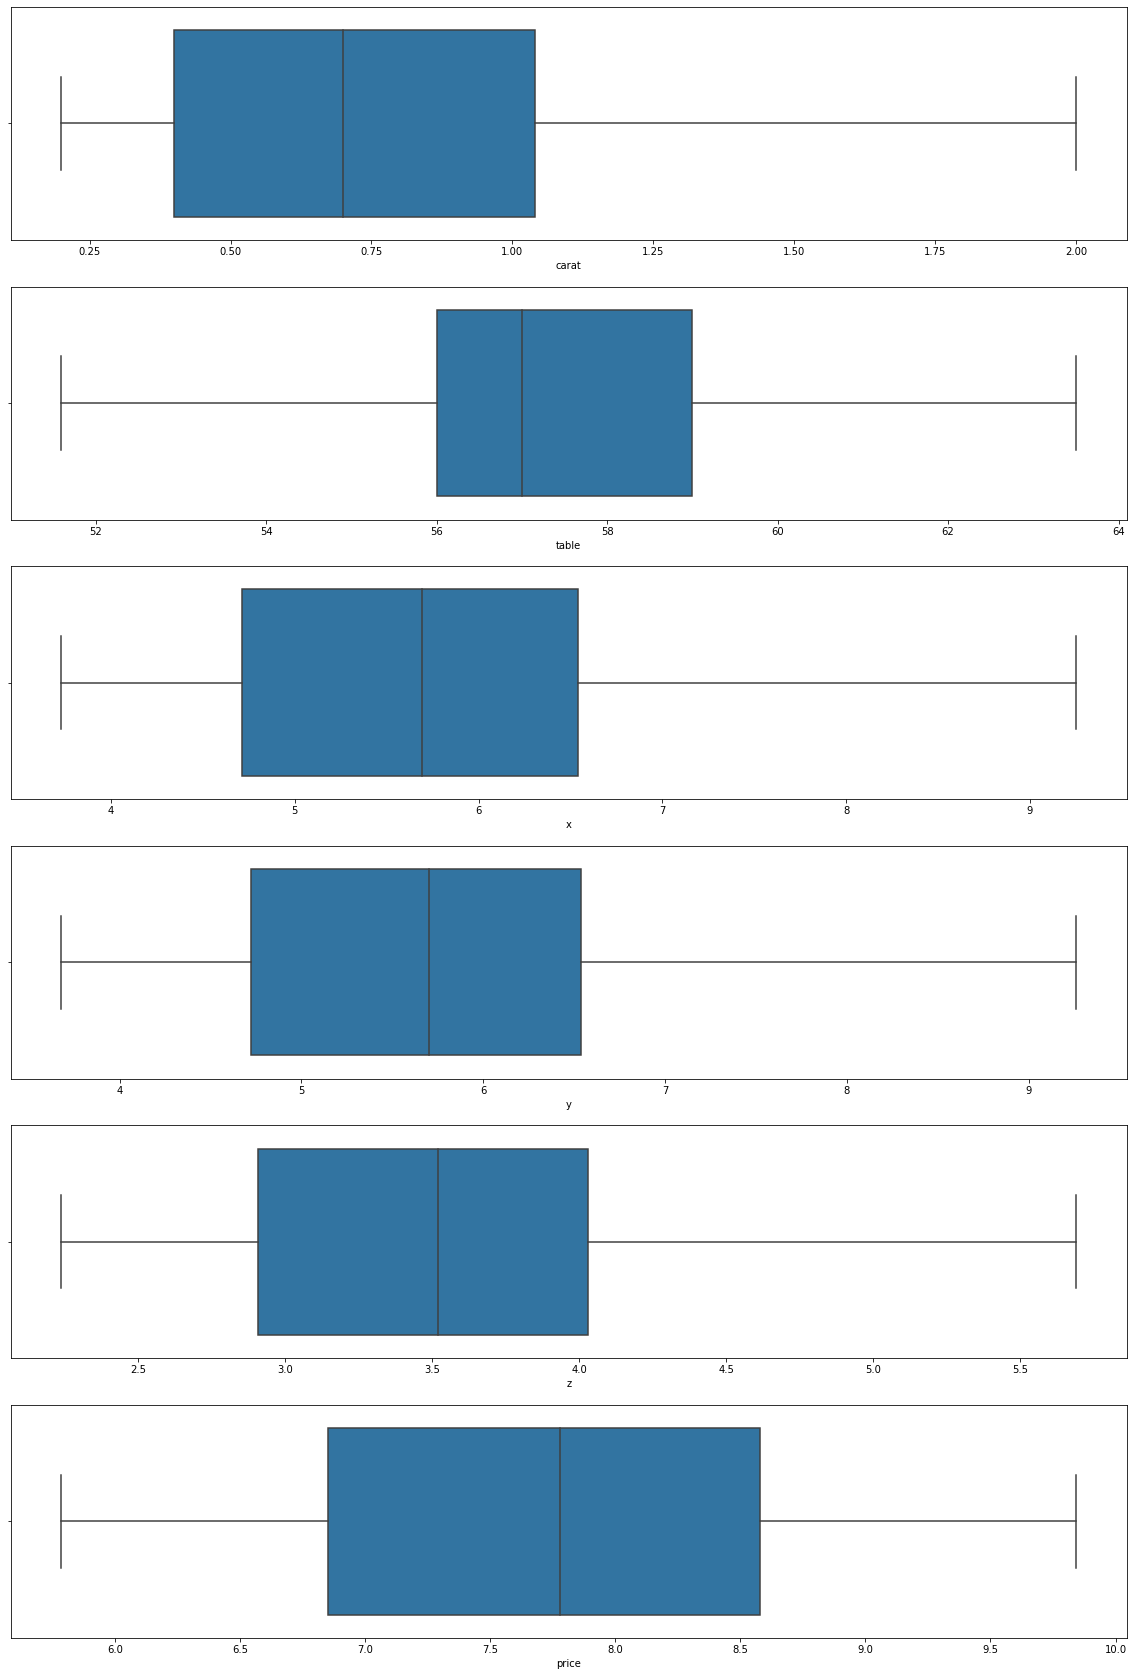

In [108]:
fig, ax = plt.subplots(6, 1, figsize=(20,30))

df_number = df_train2[['carat', 'table', 'x', 'y', 'z', 'price']]
for i in range(len(df_number.columns)):
    sns.boxplot(x = df_number.columns[i], data = df_number, ax = ax[i])
plt.show();

<h2>Estandarización</h2>

In [109]:
robust = RobustScaler()

In [110]:
robust.fit(df_train2[['carat', 'x', 'y', 'z']])

RobustScaler()

In [111]:
X_robust = robust.transform(df_train2[['carat', 'x', 'y', 'z']])

In [112]:
df_train3 = df_train2.copy()

In [113]:
df_train3[['carat', 'x', 'y', 'z']] = X_robust
df_train3.head()

,id,carat,cut,color,clarity,table,x,y,z,price
0,0,-0.625000,Premium,D,SI2,58.0,-0.754098,-0.780220,-0.750000,6.353
1,1,0.484375,Ideal,E,VVS2,56.0,0.398907,0.417582,0.464286,9.183
2,2,0.031250,Ideal,F,VS2,59.0,0.010929,0.021978,0.017857,7.983
3,3,0.593750,Very Good,G,SI2,57.0,0.464481,0.439560,0.535714,8.371
4,4,-0.531250,Premium,G,VS1,59.0,-0.650273,-0.631868,-0.625000,6.588


In [114]:
with open('../data/modelo_3/estandarizacion.pkl', 'wb') as s:
    pickle.dump(robust, s)

<h2>Encoding</h2>

In [115]:
df_train4 = df_train3.copy()

In [116]:
df_train4 = sp.ordinal_encoder(df_train4, "cut", ["Ideal", "Very Good", "Good", "Premium", "Fair"], 3)

In [117]:
df_train4 = sp.ordinal_encoder(df_train4, "color", ["E", "D", "F", "G", "H", "I", "J"], 3)

In [118]:
df_train4 = sp.ordinal_encoder(df_train4, "clarity", ["VVS1", "IF", "VVS2", "VS1", "VS2", "SI1", "I1", "SI2"], 3)

In [119]:
df_train4.head()

,id,carat,cut,color,clarity,table,x,y,z,price,cut_mapeada,color_mapeada,clarity_mapeada
0,0,-0.625000,Premium,D,SI2,58.0,-0.754098,-0.780220,-0.750000,6.353,3,1,7
1,1,0.484375,Ideal,E,VVS2,56.0,0.398907,0.417582,0.464286,9.183,0,0,2
2,2,0.031250,Ideal,F,VS2,59.0,0.010929,0.021978,0.017857,7.983,0,2,4
3,3,0.593750,Very Good,G,SI2,57.0,0.464481,0.439560,0.535714,8.371,1,3,7
4,4,-0.531250,Premium,G,VS1,59.0,-0.650273,-0.631868,-0.625000,6.588,3,3,3


In [120]:
df = df_train4.copy()
df = df_train4[['carat', 'x', 'y', 'z', 'cut_mapeada', 'color_mapeada', 'clarity_mapeada', 'price']]
df.head(5)

,carat,x,y,z,cut_mapeada,color_mapeada,clarity_mapeada,price
0,-0.625000,-0.754098,-0.780220,-0.750000,3,1,7,6.353
1,0.484375,0.398907,0.417582,0.464286,0,0,2,9.183
2,0.031250,0.010929,0.021978,0.017857,0,2,4,7.983
3,0.593750,0.464481,0.439560,0.535714,1,3,7,8.371
4,-0.531250,-0.650273,-0.631868,-0.625000,3,3,3,6.588


<h2>Decision Tree</h2>

In [121]:
X = df.drop("price", axis = 1)
y = df["price"] 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 42)

In [122]:
y_train.describe()

count    36394.000000
mean         7.785014
std          1.015915
min          5.787000
25%          6.851000
50%          7.782000
75%          8.579000
max          9.842000
Name: price, dtype: float64

In [123]:
y_test.describe()

count    4044.000000
mean        7.768586
std         1.023411
min         5.823000
25%         6.848000
50%         7.739000
75%         8.586000
max         9.839000
Name: price, dtype: float64

In [124]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [125]:
max_features = np.sqrt(len(X_train.columns))
max_features

2.6457513110645907

In [126]:
print(regressor.tree_.max_depth)

32


In [127]:
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

In [128]:
dt_results1 = sp.metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.08620,0.015879,0.126013,0.984835,test,Decission Tree I
1,0.00039,0.000032,0.005641,0.999969,train,Decission Tree I


In [129]:
df_all = dt_results1.copy()

In [130]:
# Generación del GridSearch
# ==============================================================================

# definimos un diccionario con los hiperparámetros que queremos testear. 
param = {"max_depth": [4, 5, 6, 7, 8, 9, 10],
        "min_samples_split": [10, 20, 30, 40, 50, 100],
        "max_features": [2, 3, 4, 5, 6, 7]}

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [131]:
%%time
gs.fit(X_train, y_train)

CPU times: total: 7.33 s
Wall time: 23.6 s


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'max_features': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [10, 20, 30, 40, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [132]:
best_tree = gs.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=10, max_features=7, min_samples_split=20)

In [133]:
y_pred_test_dt = gs.predict(X_test)
y_pred_train_dt = gs.predict(X_train)

In [134]:
dt_results2 = sp.metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.089744,0.013881,0.117819,0.986743,test,Decission Tree II
1,0.082195,0.011533,0.107391,0.988825,train,Decission Tree II


In [135]:
df_all = pd.concat([df_all, dt_results2 ], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.086200,0.015879,0.126013,0.984835,test,Decission Tree I
1,0.000390,0.000032,0.005641,0.999969,train,Decission Tree I
0,0.089744,0.013881,0.117819,0.986743,test,Decission Tree II
1,0.082195,0.011533,0.107391,0.988825,train,Decission Tree II


<h2>Random Forest</h2>

In [136]:
param = {"max_depth": [5, 6, 7, 8, 9],
        "min_samples_split": [10, 20, 40, 50, 70,],
        "max_features": [2, 3, 4, 5, 6]}

bosque = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [137]:
%%time
bosque.fit(X_train, y_train)

CPU times: total: 11.3 s
Wall time: 9min 45s


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'max_features': [2, 3, 4, 5, 6],
                         'min_samples_split': [10, 20, 40, 50, 70]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [138]:
bos = bosque.best_estimator_
bos

RandomForestRegressor(max_depth=9, max_features=6, min_samples_split=10)

In [139]:
y_pred_test_rf = bos.predict(X_test)
y_pred_train_rf = bos.predict(X_train)

In [140]:
rf_results = sp.metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.086250,0.012453,0.111595,0.988107,test,Random Forest
1,0.082161,0.011410,0.106818,0.988944,train,Random Forest


In [141]:
df_all = pd.concat([df_all, rf_results ], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.086200,0.015879,0.126013,0.984835,test,Decission Tree I
1,0.000390,0.000032,0.005641,0.999969,train,Decission Tree I
0,0.089744,0.013881,0.117819,0.986743,test,Decission Tree II
1,0.082195,0.011533,0.107391,0.988825,train,Decission Tree II
0,0.086250,0.012453,0.111595,0.988107,test,Random Forest
1,0.082161,0.011410,0.106818,0.988944,train,Random Forest


In [142]:
with open('../data/modelo_3/mejor_modelo.pkl', 'wb') as modelo:
        pickle.dump(gs, modelo)